# PATH ridership over time

Cleaned + Plotted Port Authority data from https://www.panynj.gov/path/en/about/stats.html

In [1]:
from utz import *
from datetime import timedelta
from ire import export

Papermill parameters:

In [2]:
force = False
default_show = 'png'
W = 1200
H = 600
end_month = None

In [3]:
rename_stations = {
    '9thStreet': '9th Street',
    '14thStreet': '14th Street',
    '23rdStreet': '23rd Street',
    '33rdStreet': '33rd Street',
    'Pavonia/ Newport': 'Newport',
}

In [4]:
df = concat([
    read_parquet(pqt_path)
    for pqt_path in sorted(glob.glob('data/2*.pqt'))
    if fullmatch(r'\d{4}\.pqt', basename(pqt_path))
]).reset_index(level=1)
df['station'] = df.station.apply(lambda s: rename_stations.get(s, s))
df = df.set_index('station', append=True)
export(df, 'path')

Saved parquet to .ire/path.parquet


In [5]:
path = 'data/all.pqt'
if force or not exists(path):
    df.to_parquet(path)

path = 'data/all.xlsx'
if force or not exists(path):
    df.to_excel(path)

In [6]:
df = df.reset_index()
stations = df.station
df = df[~stations.str.contains('TOTAL')]
df

,month,station,avg daily,avg weekday,avg sat,avg sun,avg holiday,total,total weekday,total sat,total sun,total holiday
0,2012-01-01,Christopher Street,3619,4256,2708,2433,2040,112187,85113,10830,12163,4081
1,2012-01-01,9th Street,4087,4483,3695,3436,2533,126682,89658,14780,17178,5066
2,2012-01-01,14th Street,7370,8768,5346,4730,4041,228483,175369,21384,23648,8082
3,2012-01-01,23rd Street,6374,8345,2924,2563,3096,197597,166895,11698,12813,6191
4,2012-01-01,33rd Street,28586,34797,17350,16716,18627,886167,695937,69398,83578,37254
...,...,...,...,...,...,...,...,...,...,...,...,...
2492,2024-03-01,Journal Square,17461,20562,11378,10519,0,541289,431807,56888,52594,0
2493,2024-03-01,Grove Street,12549,15189,7623,6386,0,389024,318975,38117,31932,0
2494,2024-03-01,Exchange Place,8582,10348,5344,4402,0,266045,217317,26720,22008,0
2495,2024-03-01,Newport,9331,11565,4998,4279,0,289257,242874,24989,21394,0


In [7]:
station_hist = stations.value_counts()
station_hist

station
Christopher Street     147
Harrison               147
NEW JERSEY SUBTOTAL    147
Hoboken                147
Newport                147
Exchange Place         147
Grove Street           147
Journal Square         147
Newark                 147
9th Street             147
NEW YORK SUBTOTAL      147
WTC                    147
UPTOWN SUBTOTAL        147
33rd Street            147
23rd Street            147
14th Street            147
MONTHLY TOTAL          147
Name: count, dtype: int64

In [8]:
assert len(station_hist.value_counts()) == 1

In [9]:
if not default_show:
    default_show = None

if end_month is None:
    end_month = (df.month.max() + pd.Timedelta('32d')).strftime('%Y-%m')
end_month

'2024-04'

In [10]:
month_totals = df.drop(columns='station').groupby('month').sum()
months = month_totals.index.to_series().dt
month_idxs = months.month.rename('month_idx')
years = months.year.rename('year')
month_totals = sxs(years, month_idxs, month_totals)
month_totals

,year,month_idx,avg daily,avg weekday,avg sat,avg sun,avg holiday,total,total weekday,total sat,total sun,total holiday
month,,,,,,,,,,,,
2012-01-01,2012,1,197685,252769,107207,86186,106548,6128233,5055387,428830,430920,213096
2012-02-01,2012,2,212117,261474,114891,86595,116023,6151419,5229454,459565,346377,116023
2012-03-01,2012,3,224294,269793,129974,91947,0,6953140,5935471,649878,367791,0
2012-04-01,2012,4,214848,260699,132476,88181,0,6445477,5474674,529898,440905,0
2012-05-01,2012,5,217887,261234,129288,99553,91973,6754485,5747143,517147,398222,91973
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-01,2023,11,144701,176612,98776,70643,102591,4341068,3355636,395092,282566,307774
2023-12-01,2023,12,134640,160302,111635,69503,62099,4173801,3206013,558173,347516,62099
2024-01-01,2024,1,130928,161763,77444,52123,71714,4058752,3397068,309773,208489,143422


In [11]:
def rnd(n, ε=.01):
    if isna(n):
        return n
    N = round(n)
    err = max(n, N) / min(n, N) - 1
    if err > ε:
        raise ValueError(f'{n} too far from {N} (ε: {ε})')
    return N

num_week = (month_totals['total weekday'] / month_totals['avg weekday']).apply(rnd).rename('num weekdays')
num_sats = (month_totals['total sat'] / month_totals['avg sat']).apply(rnd).rename('num sats')
num_suns = (month_totals['total sun'] / month_totals['avg sun']).apply(rnd).rename('num suns')
num_days = (month_totals['total'] / month_totals['avg daily']).apply(rnd).rename('num days')
num_hols = (month_totals['total holiday'] / month_totals['avg holiday']).apply(rnd).rename('num holidays').fillna(0).astype(int)
nums = sxs(num_week, num_sats, num_suns, num_days, num_hols)
nums['num weekends'] = num_sats + num_suns
nums

,num weekdays,num sats,num suns,num days,num holidays,num weekends
month,,,,,,
2012-01-01,20,4,5,31,2,9
2012-02-01,20,4,4,29,1,8
2012-03-01,22,5,4,31,0,9
2012-04-01,21,4,5,30,0,9
2012-05-01,22,4,4,31,1,8
...,...,...,...,...,...,...
2023-11-01,19,4,4,30,3,8
2023-12-01,20,5,5,31,1,10
2024-01-01,21,4,4,31,2,8


In [12]:
m = df.merge(nums, how='left', left_on='month', right_index=True)
df['avg weekend'] = round((df['total sat'] + df['total sun']) / m['num weekends']).astype(int)
cols = df.columns.tolist()
df = df[cols[:4] + ['avg weekend'] + cols[4:-1]]
df

,month,station,avg daily,avg weekday,avg weekend,avg sat,avg sun,avg holiday,total,total weekday,total sat,total sun,total holiday
0,2012-01-01,Christopher Street,3619,4256,2555,2708,2433,2040,112187,85113,10830,12163,4081
1,2012-01-01,9th Street,4087,4483,3551,3695,3436,2533,126682,89658,14780,17178,5066
2,2012-01-01,14th Street,7370,8768,5004,5346,4730,4041,228483,175369,21384,23648,8082
3,2012-01-01,23rd Street,6374,8345,2723,2924,2563,3096,197597,166895,11698,12813,6191
4,2012-01-01,33rd Street,28586,34797,16997,17350,16716,18627,886167,695937,69398,83578,37254
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2492,2024-03-01,Journal Square,17461,20562,10948,11378,10519,0,541289,431807,56888,52594,0
2493,2024-03-01,Grove Street,12549,15189,7005,7623,6386,0,389024,318975,38117,31932,0
2494,2024-03-01,Exchange Place,8582,10348,4873,5344,4402,0,266045,217317,26720,22008,0
2495,2024-03-01,Newport,9331,11565,4638,4998,4279,0,289257,242874,24989,21394,0


In [13]:
month_totals['avg weekend'] = round((month_totals['total sat'] + month_totals['total sun']) / nums['num weekends']).astype(int)
cols = month_totals.columns.tolist()
month_totals = month_totals[cols[:4] + ['avg weekend'] + cols[4:-1]]
month_totals

,year,month_idx,avg daily,avg weekday,avg weekend,avg sat,avg sun,avg holiday,total,total weekday,total sat,total sun,total holiday
month,,,,,,,,,,,,,
2012-01-01,2012,1,197685,252769,95528,107207,86186,106548,6128233,5055387,428830,430920,213096
2012-02-01,2012,2,212117,261474,100743,114891,86595,116023,6151419,5229454,459565,346377,116023
2012-03-01,2012,3,224294,269793,113074,129974,91947,0,6953140,5935471,649878,367791,0
2012-04-01,2012,4,214848,260699,107867,132476,88181,0,6445477,5474674,529898,440905,0
2012-05-01,2012,5,217887,261234,114421,129288,99553,91973,6754485,5747143,517147,398222,91973
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-01,2023,11,144701,176612,84707,98776,70643,102591,4341068,3355636,395092,282566,307774
2023-12-01,2023,12,134640,160302,90569,111635,69503,62099,4173801,3206013,558173,347516,62099
2024-01-01,2024,1,130928,161763,64783,77444,52123,71714,4058752,3397068,309773,208489,143422


In [14]:
month_totals[month_totals.year == 2012]

,year,month_idx,avg daily,avg weekday,avg weekend,avg sat,avg sun,avg holiday,total,total weekday,total sat,total sun,total holiday
month,,,,,,,,,,,,,
2012-01-01,2012,1,197685,252769,95528,107207,86186,106548,6128233,5055387,428830,430920,213096
2012-02-01,2012,2,212117,261474,100743,114891,86595,116023,6151419,5229454,459565,346377,116023
2012-03-01,2012,3,224294,269793,113074,129974,91947,0,6953140,5935471,649878,367791,0
2012-04-01,2012,4,214848,260699,107867,132476,88181,0,6445477,5474674,529898,440905,0
2012-05-01,2012,5,217887,261234,114421,129288,99553,91973,6754485,5747143,517147,398222,91973
2012-06-01,2012,6,220583,265070,116770,125922,105328,0,6617439,5566513,629613,421313,0
2012-07-01,2012,7,215812,265126,109675,124534,97788,135395,6690150,5567676,498137,488942,135395
2012-08-01,2012,8,219127,256280,112315,124030,100598,0,6792920,5894399,496124,402397,0
2012-09-01,2012,9,211823,267481,117874,131998,103752,93810,6354673,5082119,659987,518757,93810


In [15]:
from calendar import month_abbr
pivoted = (
    month_totals
    .assign(month=month_totals.month_idx.apply(lambda m: month_abbr[m]))
    .set_index(['month_idx', 'month'])
    [['year', 'avg weekday', 'avg weekend', 'avg sat', 'avg sun']]
    .pivot(columns='year')
    .replace(nan, 0).astype(int)
    .sort_index()
    .reset_index(level=0, drop=True)
)
pivoted

avg weekday                                                          \
year         2012    2013    2014    2015    2016    2017    2018    2019   
month                                                                       
Jan        252769  217347  231474  227561  250485  266846  266614  272334   
Feb        261474  233634  233112  245225  259235  266278  279694  278046   
Mar        269793  235594  248144  250489  265131  266744  264985  281604   
Apr        260699  248689  252737  258354  270123  289352  284284  285928   
May        261234  249230  255113  264328  271904  284093  291747  289413   
Jun        265070  252260  259002  267051  277947  288215  291075  292317   
Jul        265126  250019  258041  267494  272797  297494  281776  288162   
Aug        256280  245527  250156  259296  269440  297000  275442  281487   
Sep        267481  256738  258152  269042  278139  293422  289129  298518   
Oct        233819  259233  262366  274486  276416  297032  299788  296977   
Nov        121496  252038  253716  268329  277473  291558  287651  290128   
Dec        185834  233064  237434  248433  258948  265519  258220  257960   

                                              avg weekend                  \
year     2020    2021    2022    2023    2024        2012    2013    2014   
month                                                                       
Jan    277232   56904   84185  145637  161763       95528   71794   82017   
Feb    282852   52604  113248  150238  171389      100743   76570   94185   
Mar    126408   64332  132441  155241  177644      113074   99112   92322   
Apr     14597   70157  135339  161954       0      107867  105666   97936   
May     20447   79652  140303  171363       0      114421  101889  101516   
Jun     34366   91755  148025  164558       0      116770  109826  101138   
Jul     47027   99232  138960  162385       0      109675  101328   95779   
Aug     54124   98423  138504  162577       0      112315  109008   93828   
Sep     62651  113599  157982  178948       0      117874  109078   96406   
Oct     65841  124727  158481  185147       0      114902  109497   95562   
Nov     61755  128095  155527  176612       0       43762   99845   89674   
Dec     55354  112664  139597  160302       0       69253  103426  101367   

                                                                           \
year     2015    2016    2017    2018    2019   2020   2021   2022   2023   
month                                                                       
Jan     78583   77728   86785   85625   73360  74503  30711  42657  69586   
Feb     82079   89792   95271   88136   81987  82704  32741  60742  69142   
Mar     92511  101323   92524  103004   87887  36523  40567  64201  74664   
Apr    106301  104506  107947  103954   96568   6935  44542  74555  77752   
May    107425  101678  101782  100587   97908  10891  50145  71893  89091   
Jun    107012  107583  111428  110272  101676  18902  65780  82836  89449   
Jul    104195  101454  106582   91842   90233  25766  65200  75270  82763   
Aug    107570   87769  107192   88646   98577  30635  59512  77925  86589   
Sep    109970   96233  111447   96501  101705  38917  73652  86048  83802   
Oct    110087   88010  107386   89491   96709  41379  74408  82763  86658   
Nov    102266   91880  101310  100141   93909  35455  73318  80947  84707   
Dec    111703   90492  103127  111746  107070  31694  66333  73965  90569   

             avg sat                                                          \
year    2024    2012    2013    2014    2015    2016    2017    2018    2019   
month                                                                          
Jan    64783  107207   81710   91282   88875   87876   97008  100665   84349   
Feb    75690  114891   83702  109729   94726  102089  110189  101733   94429   
Mar    79578  129974  118284  110695  107723  119979  107588  118685  106134   
Apr        0  132476  122783  112771  122707  117505  1218

In [16]:
import plotly.express as px
from IPython.display import Image

In [17]:
gridcolor = '#ccc'

def default_plot(fig):
    return (
        fig
        .update_layout(
            title_x=0.5,
            paper_bgcolor='white',
            plot_bgcolor='white',
            legend=dict(traceorder='reversed'),
            hovermode='x',
        ).update_xaxes(
            tickangle=-45,
            gridcolor=gridcolor,
        ).update_traces(
            hovertemplate=None,
        ).update_yaxes(
            gridcolor=gridcolor,
            hoverformat=",",
        )
    )

In [18]:
def stations_stack(
    y, title, name=None,
    start=None, end=None,
    dtick=None, tickangle=-45,
    width=W, height=H,
    show=default_show,
):
    if isinstance(start, str):
        start = to_dt(start)
    start = start or to_dt('2012')
    start -= timedelta(days=15)
    if isinstance(end, str):
        end = to_dt(end)
    end = end or to_dt(end_month)
    end -= timedelta(days=15)
    dims = dict(width=width, height=height)
    fig = default_plot(
        px.bar(
            df,
            x='month', y=y, color='station',
            title=title,
            labels={
                'station': 'Station',
                y: title,
                'month': 'Month',
            }
        )
    ).update_xaxes(
        range=[start, end],
        dtick=dtick,
    ).update_layout(**dims)
    if name:
        path = f'img/{name}.png'
        print(f'Saving {path}')
        fig.write_image(path, **dims)
    return export(fig, name, show=show)

Saving img/weekdays.png


Saved plotly to .ire/weekdays.json


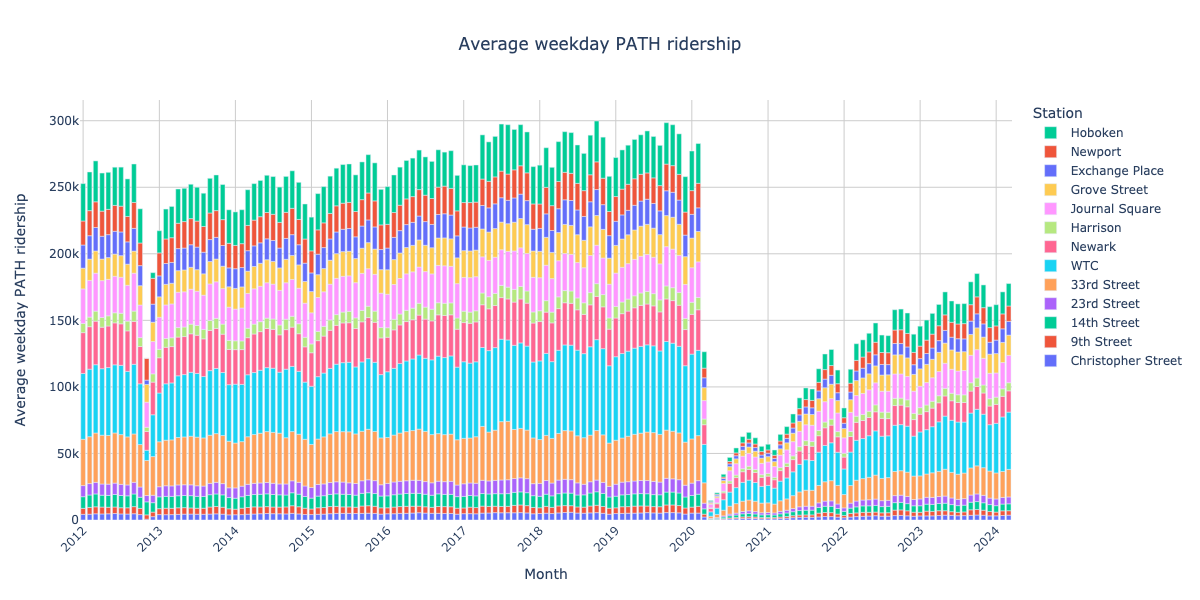

In [19]:
stations_stack(
    'avg weekday',
    'Average weekday PATH ridership',
    dtick="M12",
    name='weekdays',
)

Saving img/weekdays_2020:.png


Saved plotly to .ire/weekdays_2020:.json


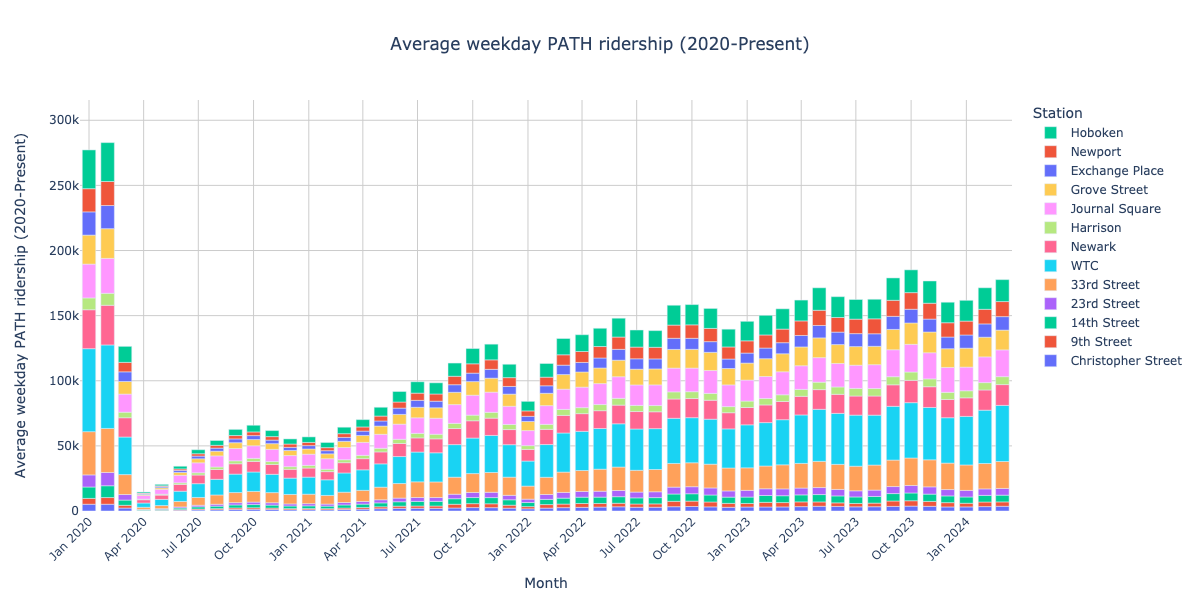

In [20]:
stations_stack(
    'avg weekday',
    'Average weekday PATH ridership (2020-Present)',
    name='weekdays_2020:',
    dtick='M3',
    start='2020',
)

Saving img/weekends.png


Saved plotly to .ire/weekends.json


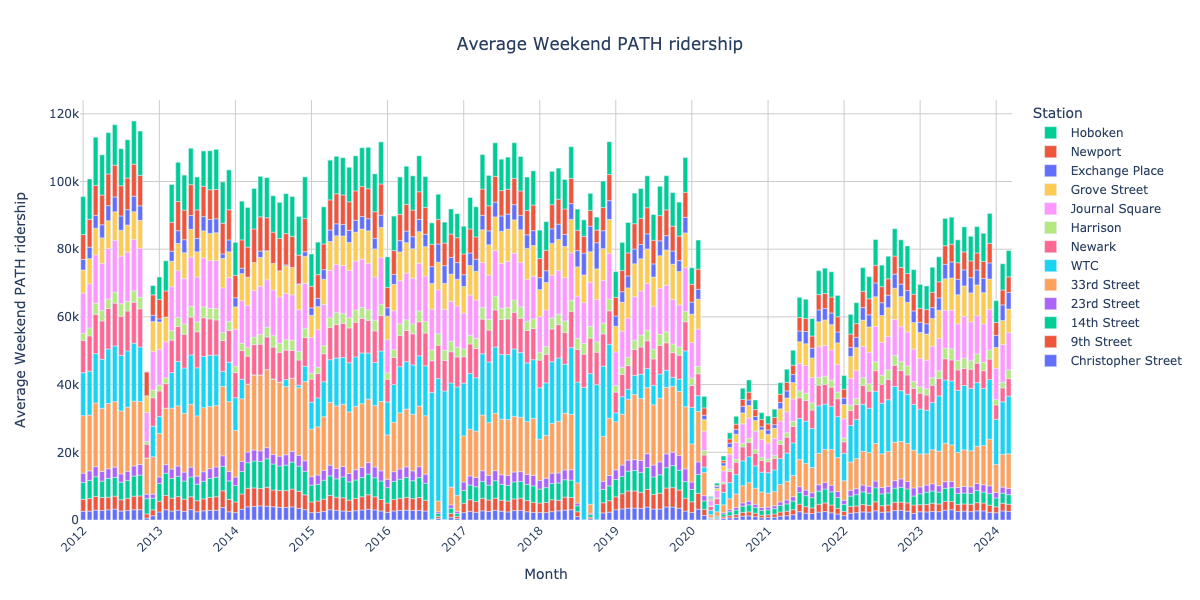

In [21]:
stations_stack(
    'avg weekend',
    'Average Weekend PATH ridership',
    dtick="M12",
    name='weekends',
)

Saving img/weekends_2020:.png


Saved plotly to .ire/weekends_2020:.json


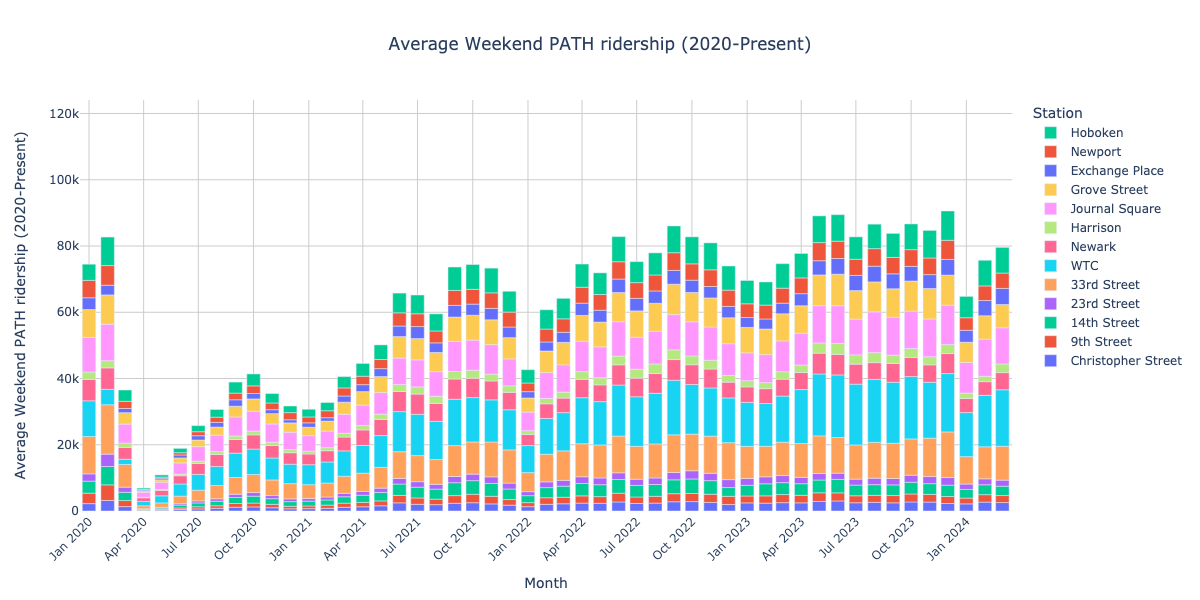

In [22]:
stations_stack(
    'avg weekend',
    'Average Weekend PATH ridership (2020-Present)',
    dtick="M3",
    name='weekends_2020:',
    start='2020',
)

In [23]:
num_years = len(month_totals.year.unique())
num_years

13

In [24]:
from utz.colors import colors_lengthen

In [25]:
px_colors = px.colors.sequential.Inferno
colors = list(reversed(colors_lengthen(px_colors, num_years)))
colors

['#fcffa4',
 '#f8dc56',
 '#f9b621',
 '#f78e0d',
 '#ed6925',
 '#d64d3d',
 '#ba3853',
 '#992863',
 '#781c6d',
 '#55106b',
 '#320c56',
 '#140931',
 '#000004']

In [26]:
month_names = [ to_dt('2022-%02d' % i).strftime('%b') for i in range(1, 13) ]
print(' '.join(month_names))

Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec


In [27]:
def grouped_month_plot(y, title, width=W, height=H, show=default_show):
    fig = px.bar(
        month_totals,
        x='month_idx', y=y,
        color=month_totals.year.astype(str),
        color_discrete_sequence=colors,
        labels={
            'color': 'Year',
            'month_idx': 'Month',
            y: title,
        },
        barmode='group',
    )
    dims = dict(width=width, height=height)
    fig = fig.update_layout(
        title=f'{title} (grouped by month)',
        title_x=0.5,
        xaxis=dict(
            tickmode = 'array',
            tickvals = list(range(1, 13)),
            ticktext = month_names,
        ),
        **dims,
    )
    name = f'{y}_month_grouped.png'
    path = f'img/{name}'
    fig.write_image(path, **dims)
    return export(fig, name, show=show)

Saved plotly to .ire/avg weekday_month_grouped.png.json


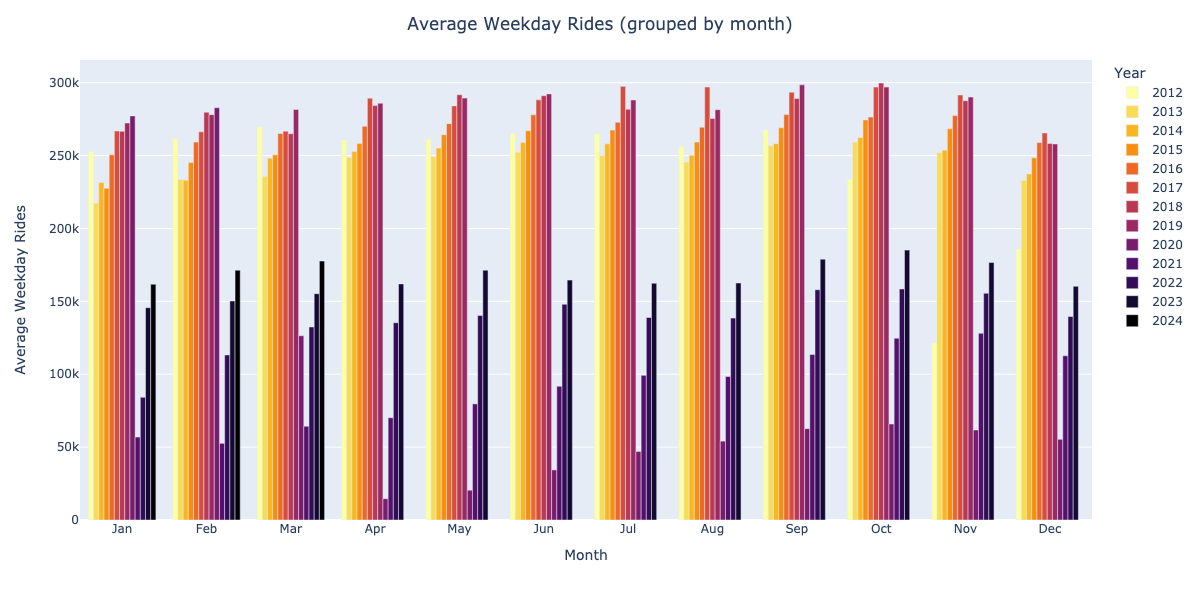

In [28]:
grouped_month_plot('avg weekday', 'Average Weekday Rides')

Saved plotly to .ire/avg weekend_month_grouped.png.json


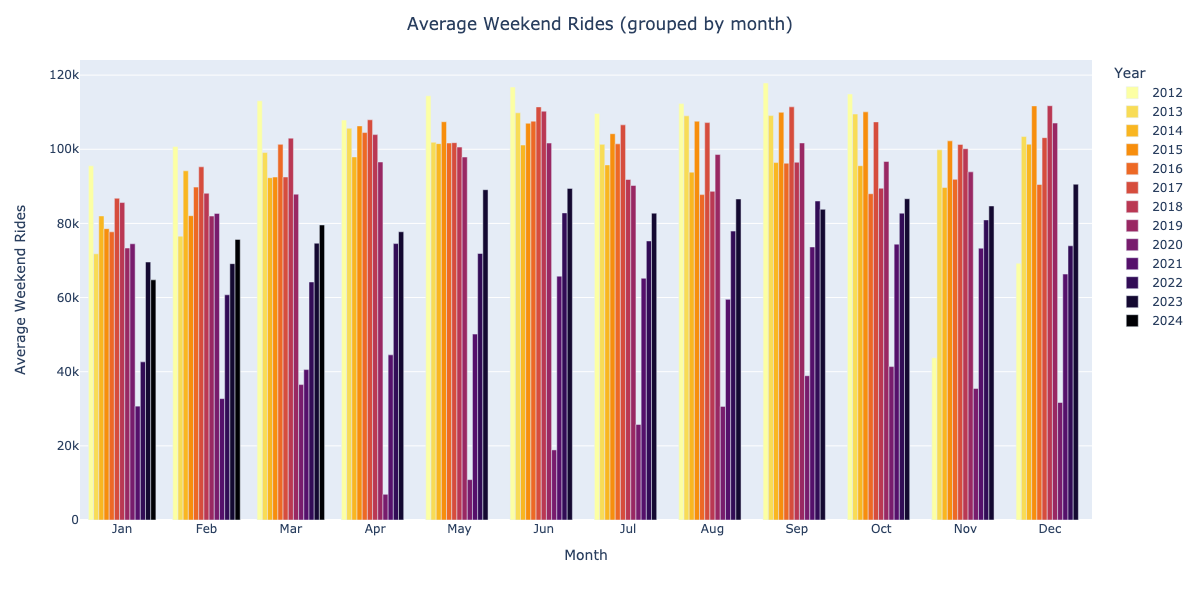

In [29]:
grouped_month_plot('avg weekend', 'Average Weekend Rides')

In [30]:
def lines(df, title, xaxis, name, xtick=None, ytick=None, width=W, height=H, show=default_show):
    dims = dict(width=width, height=height)
    fig = default_plot(
        px.line(
            df,
            title=title,
            labels={
                'variable': '',
                'value': xaxis,
                'month': 'Month',
            }
        )
    ).update_layout(
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99,
        ),
        **dims,
    ).update_xaxes(
        dtick=xtick,
        #ticklabelmode="period",
    )
    if ytick:
        fig.update_yaxes(dtick=ytick)
    fig.write_image(f'img/{name}.png', **dims)
    return export(fig, name, show=show)

Saved plotly to .ire/avg_day_types.json


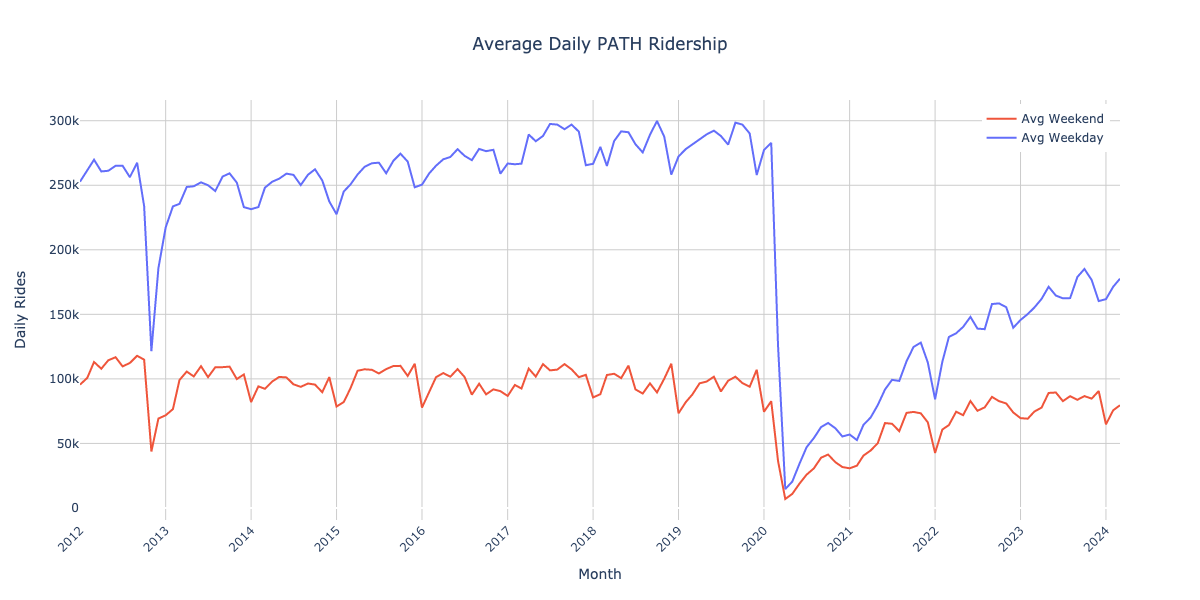

In [31]:
lines(
    month_totals[['avg weekday', 'avg weekend',]].rename(columns={
        'avg weekday': 'Avg Weekday',
        'avg weekend': 'Avg Weekend',
    }),
    title='Average Daily PATH Ridership',
    xaxis='Daily Rides',
    xtick="M12",
    name='avg_day_types',
)

## 2020-2022 Ridership vs. 2019

In [32]:
mt20 = month_totals[month_totals.index >= to_dt('2020')]
mt19 = month_totals[month_totals.year == 2019]
mt19s = pd.concat([ mt19 for i in range((len(mt20) + len(mt19) - 1) // len(mt19)) ]).iloc[:len(mt20)]

keys = ['avg weekday', 'avg weekend']
cmp19 = (
    sxs(
        mt19s.reset_index(drop=True)[keys].rename(columns={ key: f'{key} 2019' for key in keys }),
        mt20.reset_index()[keys + ['month']],
    )
    .set_index('month')
)
for k in keys:
    cmp19[f'{k} frac'] = cmp19[k] / cmp19[f'{k} 2019']
cmp19

,avg weekday 2019,avg weekend 2019,avg weekday,avg weekend,avg weekday frac,avg weekend frac
month,,,,,,
2020-01-01,272334,73360,277232,74503,1.017985,1.015581
2020-02-01,278046,81987,282852,82704,1.017285,1.008745
2020-03-01,281604,87887,126408,36523,0.448886,0.415568
2020-04-01,285928,96568,14597,6935,0.051051,0.071815
2020-05-01,289413,97908,20447,10891,0.070650,0.111237
2020-06-01,292317,101676,34366,18902,0.117564,0.185904
2020-07-01,288162,90233,47027,25766,0.163196,0.285550
2020-08-01,281487,98577,54124,30635,0.192279,0.310772
2020-09-01,298518,101705,62651,38917,0.209873,0.382646


Saved plotly to .ire/vs_2019.json


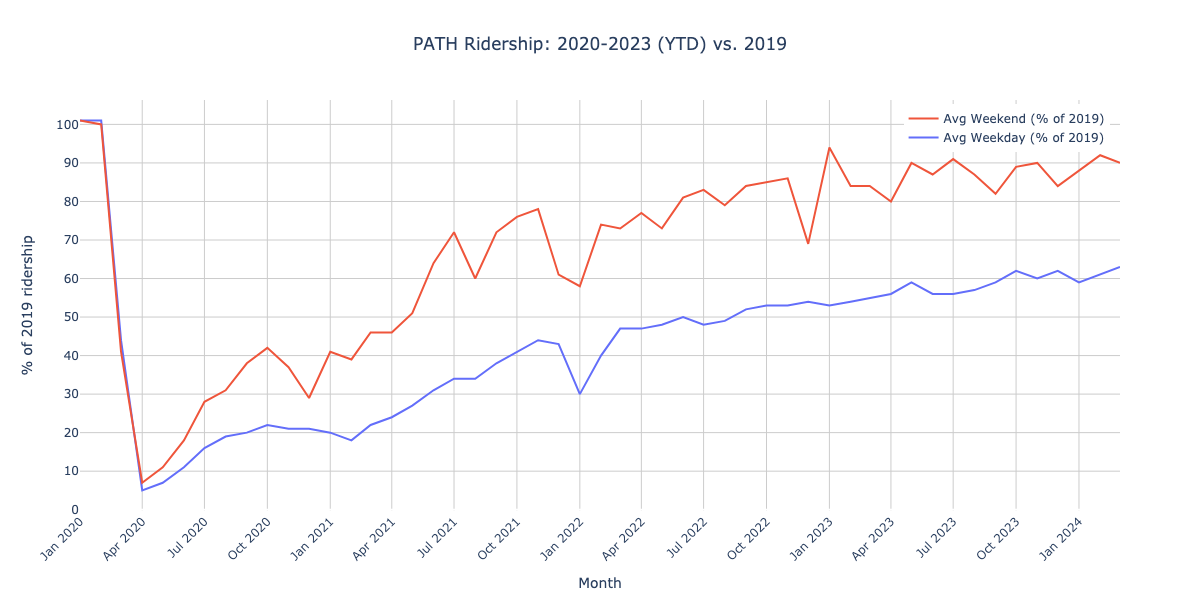

In [33]:
lines(
    (cmp19[[f'{k} frac' for k in keys]] * 100).astype(int).rename(columns={
        'avg weekday frac': 'Avg Weekday (% of 2019)',
        'avg weekend frac': 'Avg Weekend (% of 2019)',
    }),
    title='PATH Ridership: 2020-2023 (YTD) vs. 2019',
    xaxis='% of 2019 ridership',
    xtick="M3",
    ytick=10,
    name='vs_2019',
)